In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model, layers
from keras.layers import Dense #Conv1D, LSTM, MaxPool1D
from tcn import TCN, tcn_full_summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
scaler = MinMaxScaler()
df['value_met'] = scaler.fit_transform(df['value_met'].values.reshape(-1, 1))
df['value_acc'] = scaler.transform(df['value_acc'].values.reshape(-1, 1))

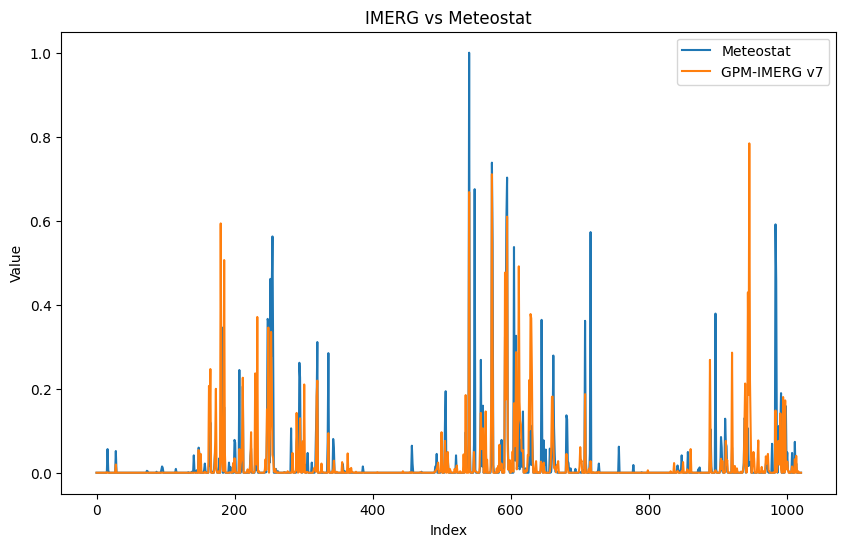

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['value_met'], label='Meteostat')
plt.plot(df['value_acc'], label='GPM-IMERG v7')
plt.title('IMERG vs Meteostat')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
batch_size = 16
epochs = 1000
window_size = 8

In [5]:
def windowed_dataset(data, window_size, batch_size, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.1, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shuffle=True)
test_set = windowed_dataset(test, window_size, batch_size, shuffle=False)

(16, 8, 1)
(8120,)
(1022,)


/var/folders/xr/qw3ngvrd31dcj2c74gp2t0c00000gn/T/ipykernel_84246/4153096080.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


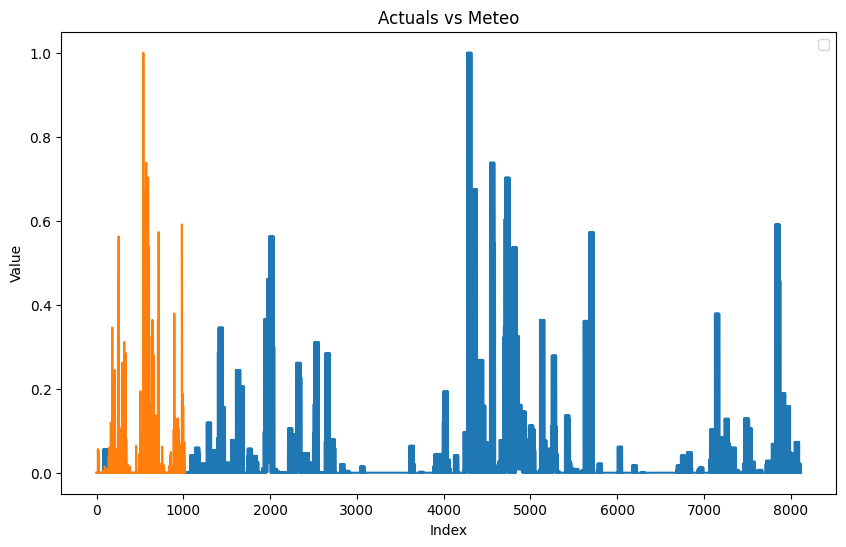

In [8]:
data = windowed_dataset(df, window_size, batch_size, shuffle=False)
actuals = [y for x, y in data]
print(actuals[0].shape)
actuals = np.concatenate(actuals, axis=0).flatten()

print(actuals.shape)
print(df['value_met'].shape)

plt.figure(figsize=(10, 6))
plt.plot(actuals)
plt.plot(df['value_met'])
plt.title('Actuals vs Meteo')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
class RootMeanSqauredError(keras.metrics.MeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(super().result())

In [10]:
def build_model():
    """
    Build a CONV-LSTM model for error correction.
    
    Returns:
    keras.Model: The compiled model
    """
    # Input layer
    inputs = layers.Input(shape=(window_size, 1))
    
    # Convolutional layers
    x = TCN(nb_filters=128, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32])(inputs)
    x = TCN(nb_filters=64, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32])(x)
    outputs = Dense(1)(x)
    
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=2000,
        decay_rate=0.9
    )

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.AdamW(lr_scheduler), loss='mse', metrics=['mae', RootMeanSqauredError(name='rmse')])
    
    return model

In [11]:
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn (TCN)                       │ (None, 8, 128)         │       542,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_1 (TCN)                     │ (None, 8, 64)          │       168,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 711,681 (2.71 MB)

 Trainable params: 711,681 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_rmse', min_delta=1e-6)]
)

Epoch 1/1000
     57/Unknown 12s 122ms/step - loss: 0.0168 - mae: 0.0479 - rmse: 0.1253

/Users/edargham/miniconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 0.0166 - mae: 0.0476 - rmse: 0.1248 - val_loss: 0.0174 - val_mae: 0.0568 - val_rmse: 0.1321
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0048 - mae: 0.0263 - rmse: 0.0687 - val_loss: 0.0131 - val_mae: 0.0516 - val_rmse: 0.1144
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0038 - mae: 0.0227 - rmse: 0.0614 - val_loss: 0.0164 - val_mae: 0.0615 - val_rmse: 0.1280
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0043 - mae: 0.0259 - rmse: 0.0653 - val_loss: 0.0179 - val_mae: 0.0598 - val_rmse: 0.1339
Epoch 5/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0040 - mae: 0.0243 - rmse: 0.0631 - val_loss: 0.0137 - val_mae: 0.0541 - val_rmse: 0.1170
Epoch 6/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0061 - mae: 0.0318 - rmse: 0.0779 - val_loss: 0.0126 - val_mae: 0.0510 - val_rmse: 0.1122
Epoch 7/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0034 - mae: 0.0221 - rms

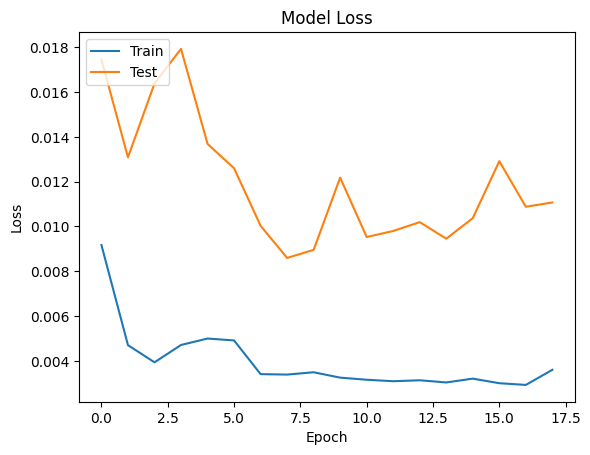

In [13]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
(96, 8, 1)
(96, 8, 1)


/Users/edargham/miniconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


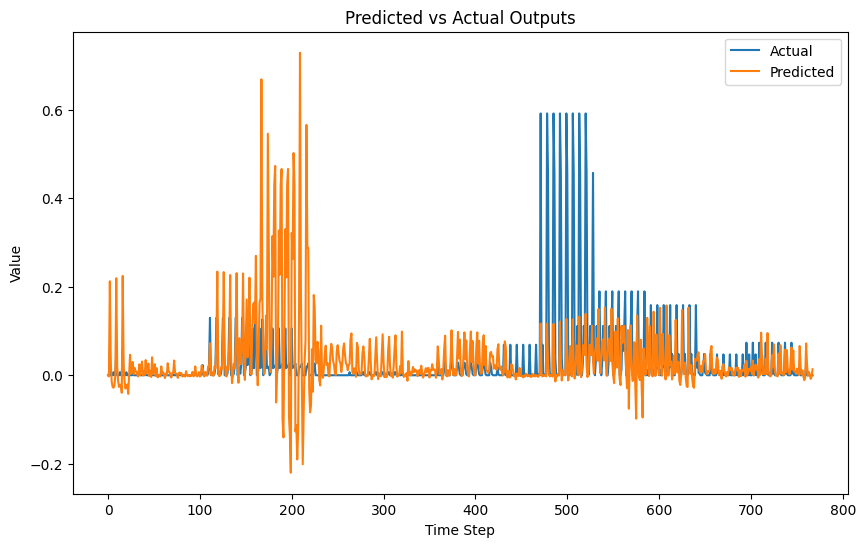

In [14]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


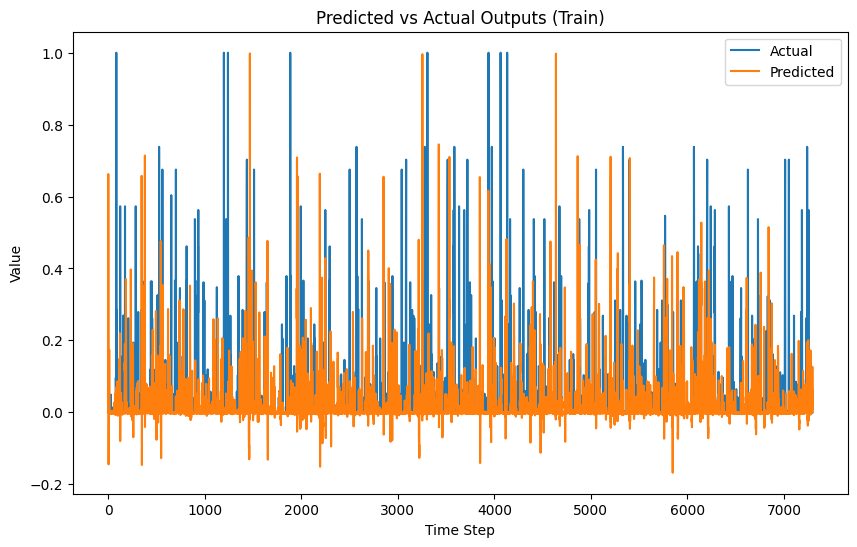

In [15]:
y_pred_train = model.predict(train_set)
y_train = np.concatenate([y for x, y in train_set], axis=0)

y_pred_train = y_pred_train.flatten()
y_train = y_train.flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_pred_train, label='Predicted')
plt.title('Predicted vs Actual Outputs (Train)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
model.save_weights('corrector-ae.weights.h5')

In [17]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-daily-precipitation.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_values = scaler.transform(beirut_values.reshape(-1, 1)).flatten()
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# Inverse transform the corrected values
corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 1)).flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()
print(len(corrected_values))
print(len(beirut_df))

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df = beirut_df[:len(corrected_values)]
beirut_df['value'] = corrected_values
beirut_df.to_csv('data/beirut-daily-corrected.csv', index=False)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
1048
1049


/Users/edargham/miniconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
